In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# Load the raw IMDB dataset
df = pd.read_csv(r"C:\Users\hp\Downloads\IMDB Dataset.csv")

print(df.head())
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [23]:
# Convert sentiment to numeric (1 = positive, 0 = negative)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Optional: basic text cleaning
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)       # remove HTML tags
    text = re.sub(r"[^a-zA-Z']", " ", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces
    return text

df['review'] = df['review'].apply(clean_text)

# Quick check
print(df.sample(3))

                                                  review  sentiment
3888   as a writer and a lapsed orthodox jewish woman...          0
24979  whereas the movie was beautifully shot and rea...          0
2004   this is a film i decided to go and see because...          1


In [25]:
# Hyperparameters
vocab_size = 20000    # number of unique words to keep
max_len = 200          # max sequence length
oov_token = "<UNK>"

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['review'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['sentiment'].values, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


In [31]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,839,681 (10.83 MB)

 Trainable params: 2,839,681 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
 12/250 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.4768 - loss: 0.6935

In [37]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.8664 - loss: 0.3459
Test Accuracy: 0.8654999732971191


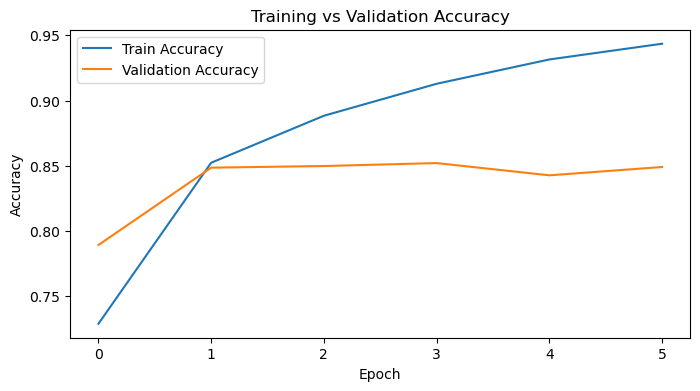

In [39]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
from tensorflow.keras.layers import GRU, Bidirectional

model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,774,657 (10.58 MB)

 Trainable params: 2,774,657 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
def predict_sentiment(review):
    seq = tokenizer.texts_to_sequences([review])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(pad)[0][0]
    sentiment = "Positive 😊" if pred > 0.5 else "Negative 😞"
    print(f"\nReview: {review}")
    print(f"Predicted Sentiment: {sentiment}")

# 🔍 Try a few examples
predict_sentiment("The movie was absolutely wonderful and emotional")
predict_sentiment("I hated every second of this boring movie")
predict_sentiment("The plot was average but the cinematography was great")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step

Review: The movie was absolutely wonderful and emotional
Predicted Sentiment: Positive 😊
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

Review: I hated every second of this boring movie
Predicted Sentiment: Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

Review: The plot was average but the cinematography was great
Predicted Sentiment: Negative 😞


In [51]:
predict_sentiment("It was boring and poorly acted")
predict_sentiment("The film was okay but could have been better")
predict_sentiment("The movie was amazing and full of emotion")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

Review: It was boring and poorly acted
Predicted Sentiment: Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Review: The film was okay but could have been better
Predicted Sentiment: Negative 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Review: The movie was amazing and full of emotion
Predicted Sentiment: Positive 😊


In [ ]:
import pickle

model.save("imdb_bilstm_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)